In [1]:
import warnings

import pandas as pd
import numpy as np

#metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
# Nomralization,standardisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#estimators
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#cross selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings(action="once")

In [3]:
df_train_raw = pd.read_excel('Data/Data_2013-2022.xlsx')

In [4]:
df_test_raw = pd.read_excel('Data/Data_2023.xlsx')
df_test_raw = df_test_raw.iloc[0:38,:]

In [5]:
def confusion(y_test, y_pred) : 
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

In [6]:
def score(estimator) :
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)

    print(f"score train : {tr_score} score test : {te_score} ")
    return te_score

# 1. Data preparation

In [7]:
#Shuffle data
df_train = df_train_raw.sample(frac=1,random_state=1).reset_index(drop=True)

In [8]:
df_train = df_train.drop(columns=["Race","Year"])
df_test = df_test_raw.drop(columns=["Race","Year"])

In [9]:
#Checking correlation between columns
print(df_train.corr()["Breakaway win"].abs().sort_values(ascending=False))

Breakaway win             1.000000
Stage classification      0.409890
elevation gain            0.390591
KM last climb - finish    0.342084
Nbr 2 cat                 0.281083
Nbr 1 cat/HC              0.254558
Nbr 3 cat                 0.210351
Stage nbr                 0.198722
Nbr 4 cat                 0.182892
length                    0.031045
Name: Breakaway win, dtype: float64


In [10]:
X_train = df_train.drop(columns="Breakaway win")
y_train = df_train["Breakaway win"]

In [11]:
X_test = df_test.drop(columns="Breakaway win")
y_test = df_test["Breakaway win"]

In [12]:
scaler = MinMaxScaler() 
#scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [13]:
list_score = {}

# 2. Modelisation

## 2.1 Dummy classifier

In [14]:
estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [15]:
cv_results['test_score']

array([0.62234043, 0.62566845, 0.62032086])

In [16]:
cv_results['test_score'].mean()

0.622776576781583

In [17]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [18]:
sum(test_score) / len(test_score)

0.5

In [19]:
dum_score = score(estimator)
list_score["Dummy classifier"] = dum_score

score train : 0.6228 score test : 0.5 


In [20]:
y_pred = estimator.predict(X_test)
dum_pred = estimator.predict(X_test)

In [21]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,19,0
test_1,19,0


In [22]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

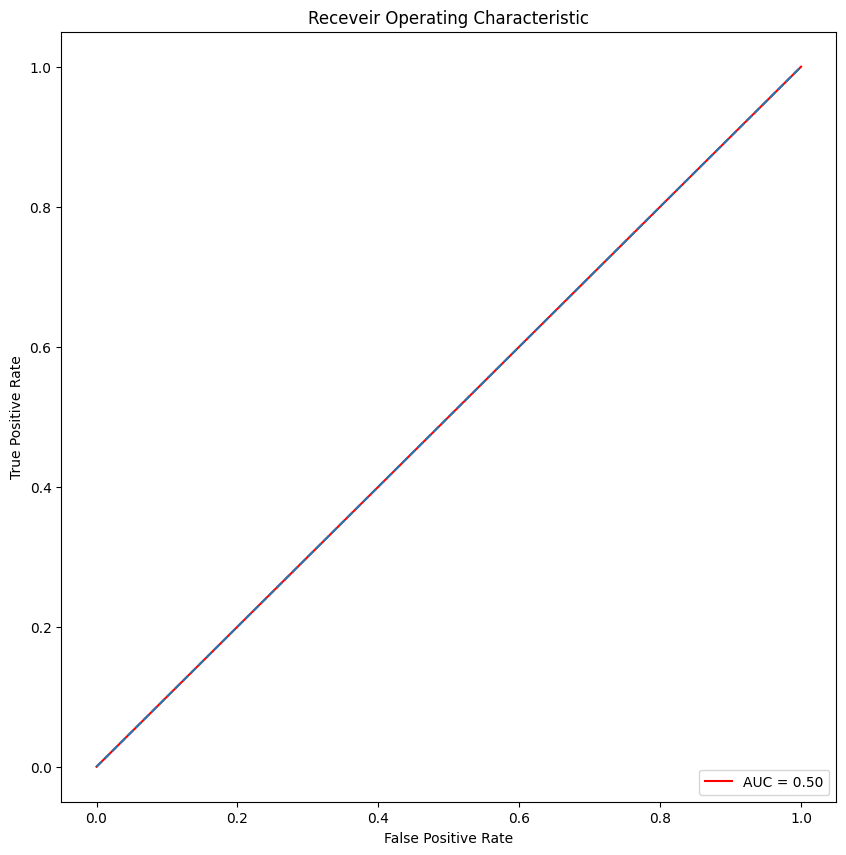

In [23]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.2 Logistic regression

Better result without Normalization

In [24]:
estimator = LogisticRegression(solver="liblinear")
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [25]:
cv_results['test_score']

array([0.68085106, 0.68449198, 0.69518717])

In [26]:
cv_results['test_score'].mean()

0.6868434027382713

In [27]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [28]:
sum(test_score) / len(test_score)

0.6666666666666666

In [29]:
log_score = score(estimator)
list_score["Logistic regression"] = log_score

score train : 0.7117 score test : 0.6316 


In [30]:
y_pred =estimator.predict(X_test)
log_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [31]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,16,3
test_1,11,8


In [32]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.631578947368421

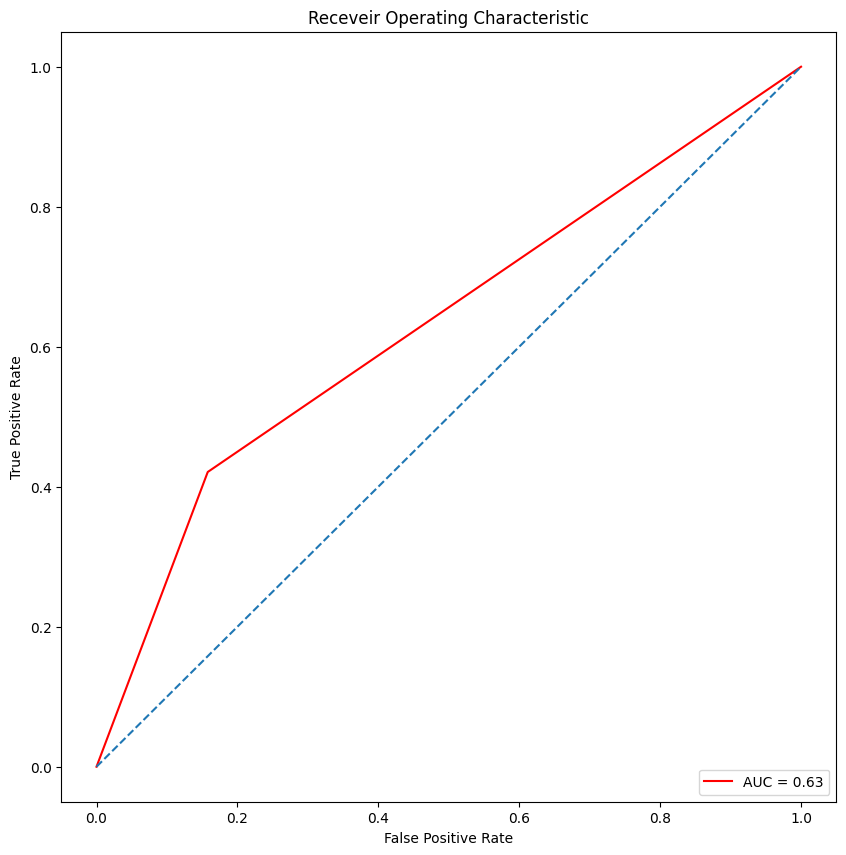

In [33]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# 2.3 SVM

Better result after Normalization

In [34]:
estimator = LinearSVC(dual=False)

In [35]:
estimator.fit(X_train_norm, y_train)
cv_results = cross_validate(estimator, X_train_norm, y_train, cv=3,return_estimator=True)

In [36]:
cv_results['test_score']

array([0.67021277, 0.70588235, 0.68983957])

In [37]:
cv_results['test_score'].mean()

0.6886448970303789

In [38]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test_norm, y_test))

In [39]:
sum(test_score) / len(test_score)

0.6754385964912281

In [40]:
tr_score = estimator.score(X_train_norm, y_train).round(4)
svm_score = estimator.score(X_test_norm, y_test).round(4)
print(f"score train : {tr_score} score test : {svm_score} ")
list_score["SVM"] = svm_score

score train : 0.7011 score test : 0.6579 


In [41]:
y_pred =estimator.predict(X_test_norm)
svm_pred = estimator.predict(X_test_norm)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [42]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,15,4
test_1,9,10


In [43]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6578947368421052

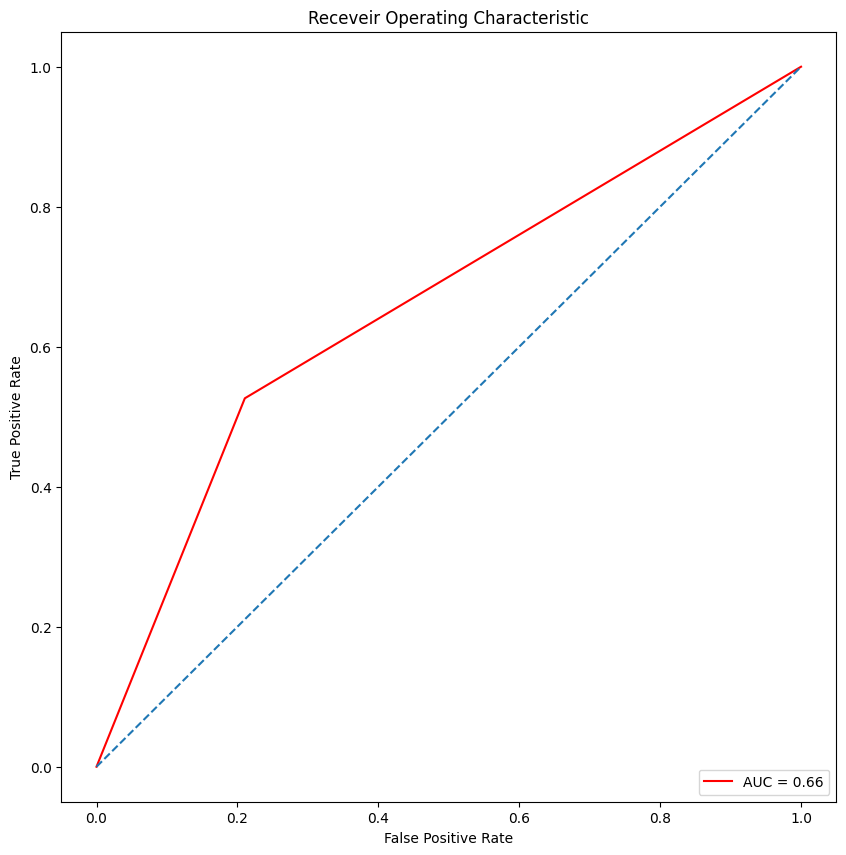

In [44]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.4 Decision trees

Better result without Normalization

In [45]:
estimator = DecisionTreeClassifier()

In [46]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [47]:
cv_results['test_score']

array([0.64361702, 0.62032086, 0.65240642])

In [48]:
cv_results['test_score'].mean()

0.6387814313346228

In [49]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [50]:
sum(test_score) / len(test_score)

0.6842105263157894

In [51]:
dt_score = score(estimator)
list_score["Decision trees"] = dt_score

score train : 1.0 score test : 0.6579 


In [52]:
y_pred =estimator.predict(X_test)
dt_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [53]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,14,5
test_1,8,11


In [54]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6578947368421053

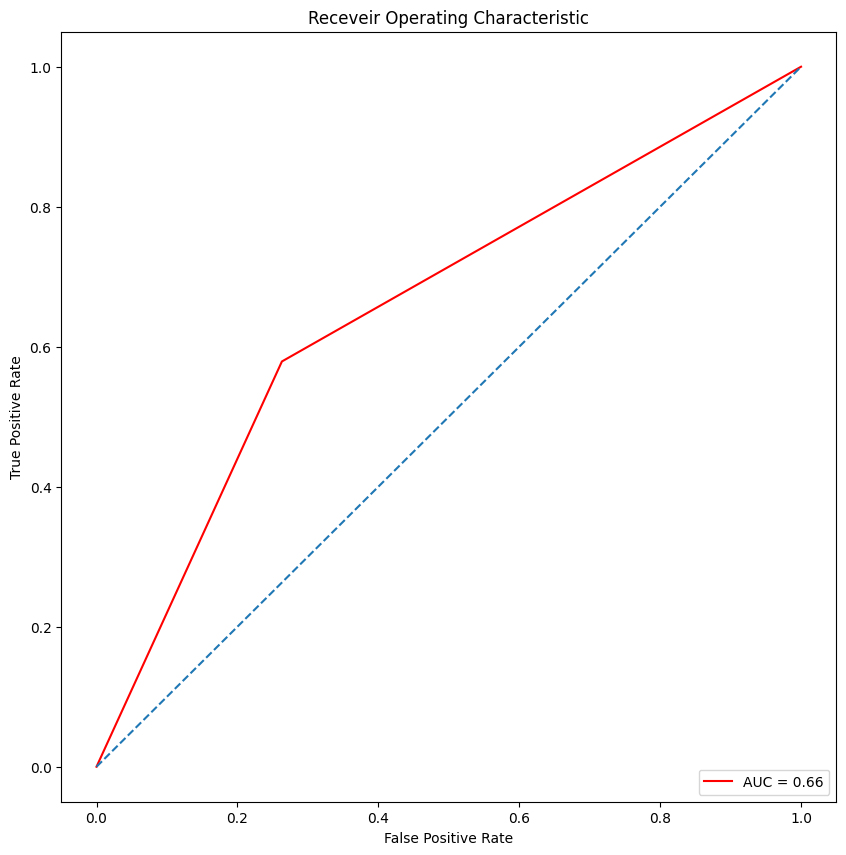

In [55]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.5 Random forest

Better result without Normalization

In [56]:
estimator = RandomForestClassifier()

In [57]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [58]:
cv_results['test_score']

array([0.72340426, 0.72727273, 0.68983957])

In [59]:
cv_results['test_score'].mean()

0.7135055182614632

In [60]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [61]:
sum(test_score) / len(test_score)

0.6842105263157895

In [62]:
rd_score = score(estimator)
list_score["Random forest"] = rd_score

score train : 1.0 score test : 0.7105 


In [63]:
y_pred =estimator.predict(X_test)
rf_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [64]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,16,3
test_1,8,11


In [65]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7105263157894737

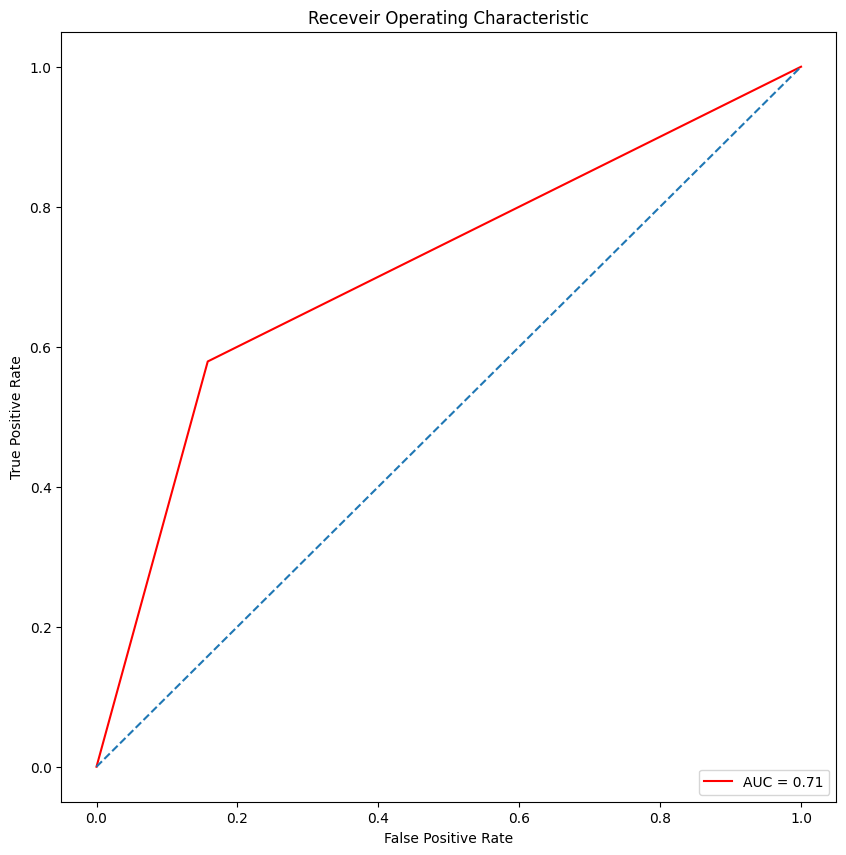

In [66]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.6 Naive Bayes

Better result without Normalization

In [67]:
estimator = GaussianNB()

In [68]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [69]:
cv_results['test_score']

array([0.71808511, 0.73796791, 0.72727273])

In [70]:
cv_results['test_score'].mean()

0.7277752493647363

In [71]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [72]:
sum(test_score) / len(test_score)

0.6929824561403509

In [73]:
nb_score = score(estimator)
list_score["Naive Bayes"] = nb_score

score train : 0.7242 score test : 0.6842 


In [74]:
y_pred =estimator.predict(X_test)
nb_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [75]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,14,5
test_1,7,12


In [76]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6842105263157895

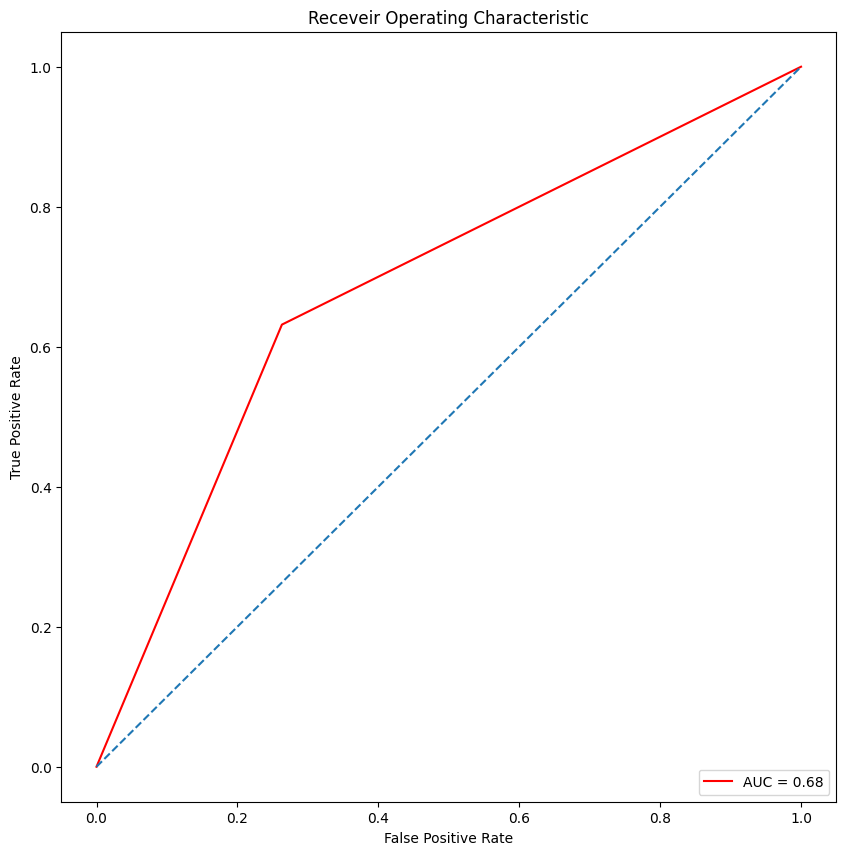

In [77]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.7 K-Nearest Neighbors

Better result after Normalization

In [78]:
estimator = KNeighborsClassifier()

In [79]:
estimator.fit(X_train_norm, y_train)
cv_results = cross_validate(estimator, X_train_norm, y_train, cv=3,return_estimator=True)

In [80]:
cv_results['test_score']

array([0.66489362, 0.73262032, 0.71122995])

In [81]:
cv_results['test_score'].mean()

0.7029146281336519

In [82]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test_norm, y_test))

In [83]:
sum(test_score) / len(test_score)

0.6491228070175439

In [84]:
tr_score = estimator.score(X_train_norm, y_train).round(4)
knn_score = estimator.score(X_test_norm, y_test).round(4)
print(f"score train : {tr_score} score test : {knn_score} ")
list_score["KNN"] = knn_score

score train : 0.8114 score test : 0.7105 


In [85]:
y_pred =estimator.predict(X_test_norm)
knn_pred = estimator.predict(X_test_norm)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [86]:
knn_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0], dtype=int64)

In [87]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,16,3
test_1,8,11


In [88]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7105263157894737

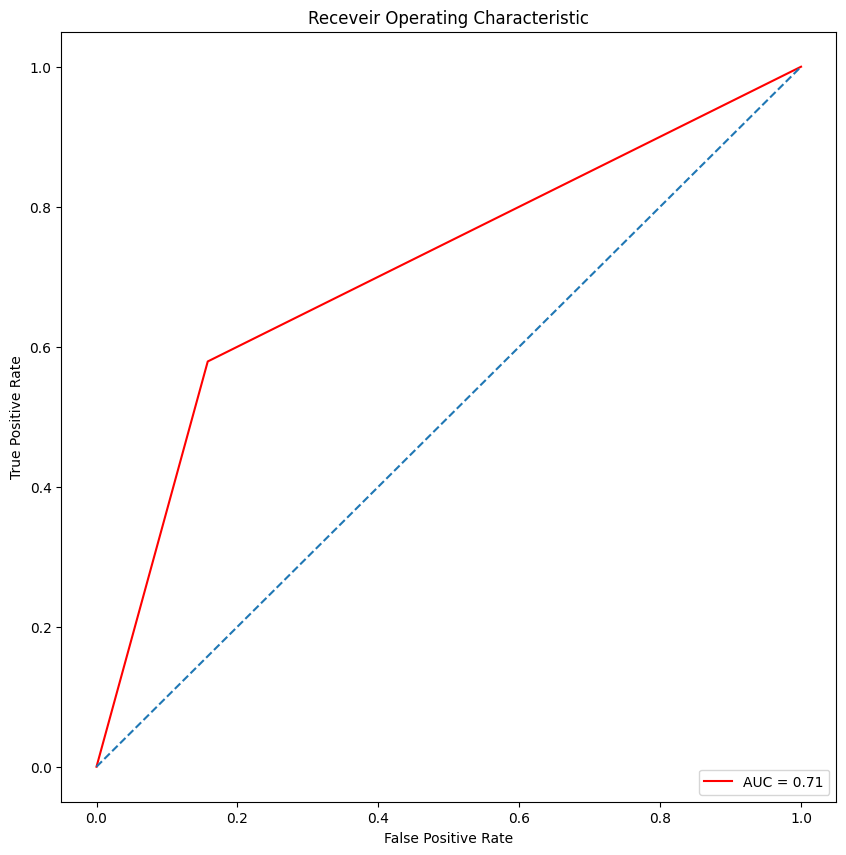

In [89]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# 3. Overall Result

In [90]:
df_result = pd.DataFrame(list(zip(df_test_raw.iloc[:,0],df_test_raw.iloc[:,2],y_test.astype(int),dum_pred,log_pred,svm_pred,dt_pred,rf_pred,nb_pred,knn_pred)),
                                              columns =["Grand Tour","Stage","Breakaway_win","Dummy pred","Logistic pred","SVM pred","Decision tree pred","Random forest pred","Naive Bayes pred","KNN pred"])

In [91]:
df_result

,Grand Tour,Stage,Breakaway_win,Dummy pred,Logistic pred,SVM pred,Decision tree pred,Random forest pred,Naive Bayes pred,KNN pred
0,Giro,2,0,0,0,0,0,0,0,0
1,Giro,3,0,0,0,0,0,0,0,0
2,Giro,4,1,0,0,1,1,1,1,1
3,Giro,5,0,0,0,0,0,0,0,0
4,Giro,6,0,0,0,0,0,0,0,0
5,Giro,7,1,0,1,1,0,1,1,0
6,Giro,8,1,0,0,0,0,1,0,0
7,Giro,10,1,0,0,0,1,0,0,1
8,Giro,11,0,0,0,0,0,0,0,0
9,Giro,12,1,0,0,1,1,1,1,0


In [92]:
list_score = list(list_score.items())

In [93]:
list_score

[('Dummy classifier', 0.5),
 ('Logistic regression', 0.6316),
 ('SVM', 0.6579),
 ('Decision trees', 0.6579),
 ('Random forest', 0.7105),
 ('Naive Bayes', 0.6842),
 ('KNN', 0.7105)]

# 4. Optimizing best algo

Considering the result score, KNN seems to give the best result on the test data (Without Vuelta for now), let's see if we can improve this score by tuning the algo

In [94]:
#Here is a reminds of the KNN score before tuning
tr_score = estimator.score(X_train_norm, y_train).round(4)
knn_score = estimator.score(X_test_norm, y_test).round(4)
print(f"score train : {tr_score} score test : {knn_score} ")

score train : 0.8114 score test : 0.7105 


## 4.1 Find best k (number of neighbors) 

In [95]:
# calculating the score of models with different values of k
mean_score = np.zeros(20)
mean_tr_score = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train_norm,y_train)
    mean_score[i-1] = knn.score(X_test_norm, y_test).round(4)
    mean_tr_score[i-1] = knn.score(X_train_norm, y_train).round(4)
    

print(mean_score)
print(mean_tr_score)

[0.6579 0.6053 0.6579 0.5789 0.7105 0.6316 0.6579 0.6316 0.6579 0.6842
 0.6842 0.6579 0.7368 0.6842 0.6842 0.6842 0.7368 0.7105 0.6842 0.6842]
[1.     0.8505 0.8345 0.806  0.8114 0.7936 0.7865 0.8007 0.7918 0.774
 0.774  0.7669 0.7633 0.7633 0.7651 0.7669 0.7562 0.7633 0.742  0.7491]


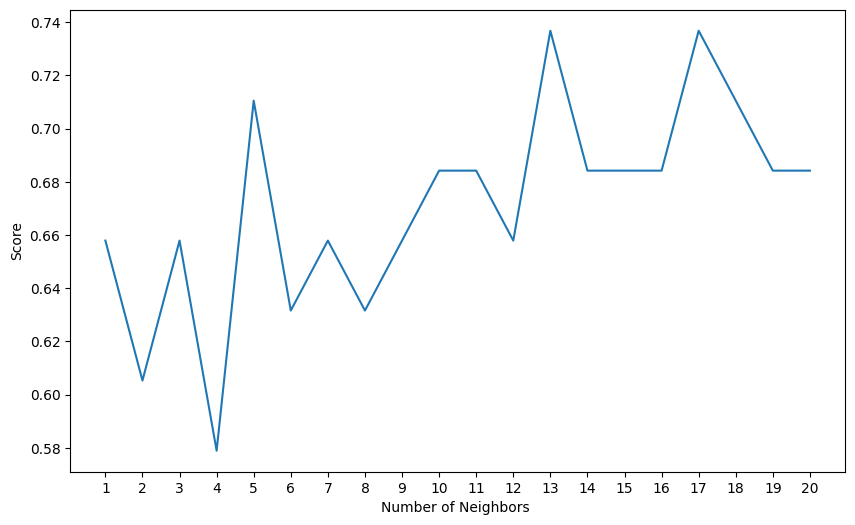

In [96]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_score)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Score')
plt.show()

The best values are [5,13,15,17,19]

## 4.2 Hyperparameter Tuning

In [97]:
#We will use the Exhaustive Grid Search technique
grid_params = { 'n_neighbors' : [5,13,15,17,19],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [98]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res = gs.fit(X_train_norm, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [99]:
# find the best score
g_res.best_score_

0.7420070542723859

In [100]:
# get the hyperparameters with the best score
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}

## 4.3 Evaluate the model after tuning

In [101]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 19, weights = 'distance',algorithm = 'brute',metric = 'manhattan')
knn.fit(X_train_norm, y_train)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=19,
                     weights='distance')

In [102]:
tr_score = knn.score(X_train_norm, y_train).round(4)
knn_score = knn.score(X_test_norm, y_test).round(4)

print(f"score train : {tr_score} score test : {knn_score} ")

score train : 1.0 score test : 0.7368 


In [103]:
y_pred =knn.predict(X_test_norm)
knn_opti_pred = knn.predict(X_test_norm)
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,16,3
test_1,7,12


In [104]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7368421052631579

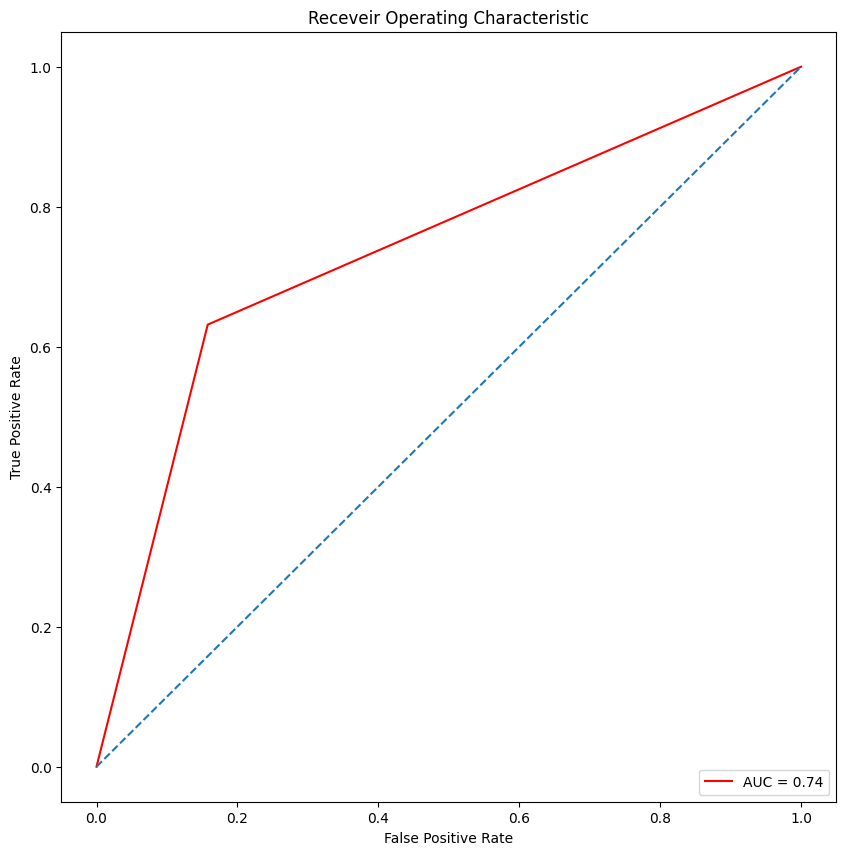

In [105]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [109]:
df_result = pd.DataFrame(list(zip(df_test_raw.iloc[:,0],df_test_raw.iloc[:,2],y_test.astype(int),knn_pred,knn_opti_pred)),
                                              columns =["Grand Tour","Stage","Breakaway_win","KNN pred","KNN opti pred"])

In [110]:
df_result

,Grand Tour,Stage,Breakaway_win,KNN pred,KNN opti pred
0,Giro,2,0,0,0
1,Giro,3,0,0,0
2,Giro,4,1,1,1
3,Giro,5,0,0,0
4,Giro,6,0,0,0
5,Giro,7,1,0,0
6,Giro,8,1,0,1
7,Giro,10,1,1,1
8,Giro,11,0,0,0
9,Giro,12,1,0,1


We can see that predictions for the Giro are much better, but worse on the Tour. 